# Chapter 3, Classification
We will work with MNIST dataset for classifying handwritten digits with the corresponding actual value. Scikit provides handy functions to get this dataset.

#### Warning!
The book uses a different method to download MNIST dataset but it seems it is not working, hence I'm using the official sickit's method to download mnist.

In [1]:
from sklearn.datasets import fetch_openml

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def print_samples(X, y, shape = (2, 2), raw=False):
    """Print n random samples"""
    if raw:
        rand_indx = np.random.randint(0, len(X), shape[0])
        samples = zip(X[rand_indx], y[rand_indx])
        print(list(samples))
    else:
        n_samples = int(shape[0]) * int(shape[1])
        rand_indx = np.random.randint(0, len(X), n_samples)
        samples = zip(X[rand_indx], y[rand_indx])
        idx = 1
        for features, label in samples:
            # X is a flattened array, to print the image we need
            # to reshape it into a 28 x 28 figure
            plt.subplot(*shape, idx)
            plt.tight_layout()
            plt.imshow(features.reshape(28,28), cmap=plt.cm.gray_r)
            plt.title("Label: {}".format(label))
            idx+=1
        plt.show()

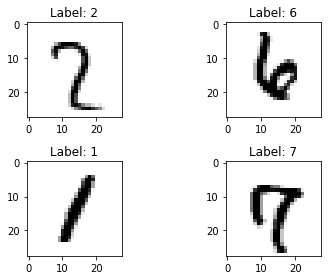

In [3]:
print_samples(X, y, (2, 2))

#### Remember!
Always create the training, validation and test set.

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Warning
You have to keep in mind the data you are dealing with and the possible algorithms and validation methods you are going to use. Some algorithms are sensitive to the order of the training set hence we don't want to feed them in the same order every time.

Also, if we are going to use k-fold cross-validation, we want to ensure that every fold get's samples of every number.

In [5]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a binary classifier
Say we want to just be able to detect if a particular sample is a 5 or not, this is an example of a binary classifier i.e., true or false.

### Warning
The way we loaded MNIST, the labels are strings not ints, hence we test with the string '5' as opposed to the int 5

In [6]:
# This simply will change the labels to True, the number is a 5, and False, is not
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

### Stochastic Gradient Descent
This algorithm handles large datasets efficiently and works on training instances independently, i.e., one at a time.

We'll use sickit's ```SGDClassifier```

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
# This means the first digit was predicted to be a five
sgd_clf.predict(X_train[10:20])

array([False, False, False, False, False, False, False, False, False,
       False])

Now let's measure the model's performance with K-fold cross validation

In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been add

array([0.954  , 0.9636 , 0.96415])

90-95% of accuracy!, very impressive, before continuing, let's see what happens when we create a model exclusively for not-5 class.

In [10]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9108 , 0.9085 , 0.90965])

Wow!, almost the same score, it seems our model is not that good after all. This is because of all the samples, only 10% of them are actually 5. So a model that predicts 90% of the time the image is not a 5 given this circumstances, it is not that useful.

This is a hint to say that 'accuracy' is not always the best metric for classifiers, especialluy when dealing with skewed datasets.

## Confusion Matrix

In [11]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been add

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[54082,   497],
       [ 1868,  3553]])

Each row of the confusion matrix represents the actual classes while each column represents the predicted values, where they cross is the correct classified categories, for instance, the first row represents non-5 and the first column represents predicted non-5, so, we could interpret as: Of all real non-5's we correctly predicted 53988.

The second column represents actual 5's, so we could read: Of all real non-5's we wrongly classified 591 as 5's.

## Concise metrics
The matrix alone is useful but we might need to calculate more concise metrics to have a better representation or "score" for the data. for instance:

### Precision
"Of all true positives and false positives, how much my model was able to hit", this metric tries to evaluate the predictions against the reality, think of it as a "row" metric.
$$
precision=\frac{TP}{TP + FP}
$$
### Recall
"Of all true positives and false negatives, how much mu model was able to hit", this metrics tries to evaluate how sensitive the predictions are, say, how much varies the predictions for a specific class, think of it as a "column" metric
$$
recall = \frac{TP}{TP + FN}
$$

In [13]:
from sklearn.metrics import precision_score, recall_score

ps = precision_score(y_train_5, y_train_pred)
rs = recall_score(y_train_5, y_train_pred)

print("Precision: ", ps)
print("Recall: ", rs)

Precision:  0.8772839506172839
Recall:  0.6554141302342741


Now the model does not look as good as before, this means it was only to correctly predict 86% of the 5s, and it was only able to detect 71% of the 5s.

### F1 score - harmonic mean of precision and recall
It is often convinient to combien both precision and recall into a single metric called $F_1 score$. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values.

$$
F_1 =\frac{2}{\frac{1}{precision}+\frac{1}{recall}} = 2\times \frac{precision\times recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}
$$

In [14]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7502903600464577

#### Precision & recall trade-off
You can't both socores high, you can increase the precision but at the same time you recall might get down and the same in opposite direction. For SGD classifier, there is a threshold for classification where the model decides if the instance is in one side or the other. If we increase the threshold, we might increase the precision, but at the same time leave other 5 instances out which translates to a lower recall. In the same sense, if we lower the threshold, we increase the recall, i.e., the model is able to detect more of them, but lower the precission by letting pass non-5 instances.

We can't mess around with the threshold value on Scikit's SGDClassifier directly, but we can try an alternative.

In [15]:
y_scores = sgd_clf.decision_function(X_train[0:1])
y_scores

array([-266332.92334364])

In [16]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print("Is a 5? ", y_some_digit_pred)
print("It was really a 5?", y_train_5[0])

Is a 5?  [False]
It was really a 5? False


With threshold 0, the default in ```SGDClassifier```, the specific instance shown above, predicts a 5. Now let's try with a different threshold.

In [17]:
threshold = 300000
y_some_digit_pred = (y_scores > threshold)
print("Is a 5? ", y_some_digit_pred)
print("It was really a 5?", y_train_5[0])

Is a 5?  [False]
It was really a 5? False


Since we can't control the threshold used by the algorithm, we will first need to get every instance individual score and play around with the values and a different threshold.

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been add

In [19]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

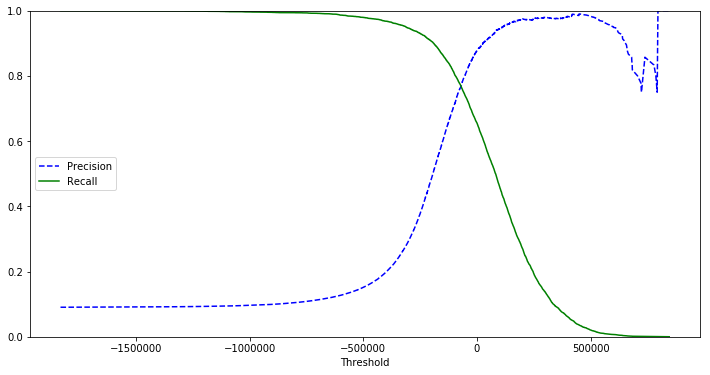

In [20]:
import matplotlib.pyplot as plt

def plot_recision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12,6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    plt.show()
    
plot_recision_recall_vs_threshold(precisions, recalls, thresholds)

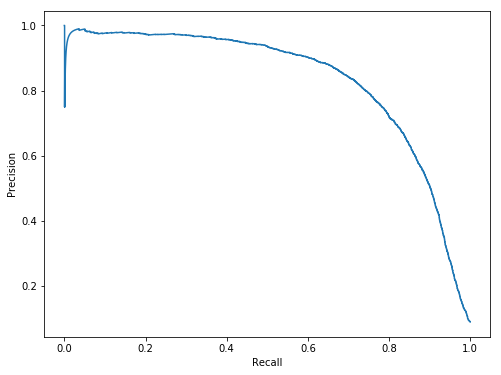

In [21]:
plt.figure(figsize=(8,6))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

Depending on the project, you will need to decide the trade-off, from the plot above, you can observe the precision drops sharply around 80% of recall, so one option would be to aim for a 60% of recall.

For instance, say you want to aim for 90% of precision, according to the Recall VS Precision plot, you might want to try a threshold of 70000 for that.

In [22]:
y_train_pred_90 = (y_scores > 70000)
ps = precision_score(y_train_5, y_train_pred_90)
rs = recall_score(y_train_5, y_train_pred_90)
print("Precision score: ", ps)
print("Recall score: ", rs)

Precision score:  0.9267255479228002
Recall score:  0.5225973067699686


### The receiver operating characteristic (ROC) curve
This is a common tool for binary classifiers. It's similar to precision vs recall curve, but compares *true positive rate* (another name for recall) and *false positive rate*. The FPR is the ratio of negative instances that are incorreclty classified as positive.

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [24]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(12, 6))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0,1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

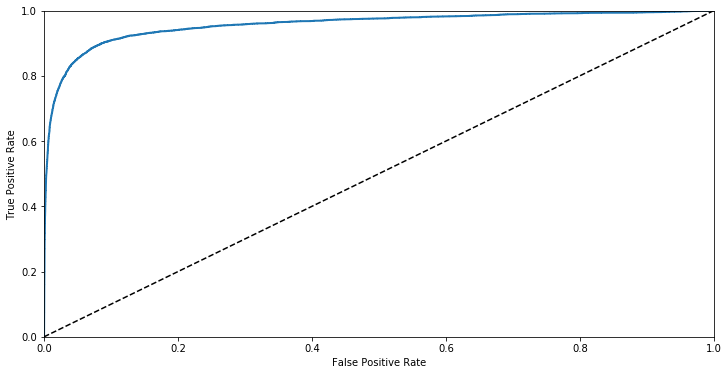

In [25]:
plot_roc_curve(fpr, tpr)

The dotted line represents a random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the *the area under the curve* (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

In [26]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.957138521157333

### Train a ```RandomForestClassifier``` and plot the PR and ROC curves

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(rf_clf, X_train, y_train_5, cv=3, method="predict_proba")

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


To plot ROC curve you need scores, not probabilities. A simple solution is to use the positive class's probability as the score

In [28]:
y_scores_forest = y_probas_forest[:,1] # socre = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

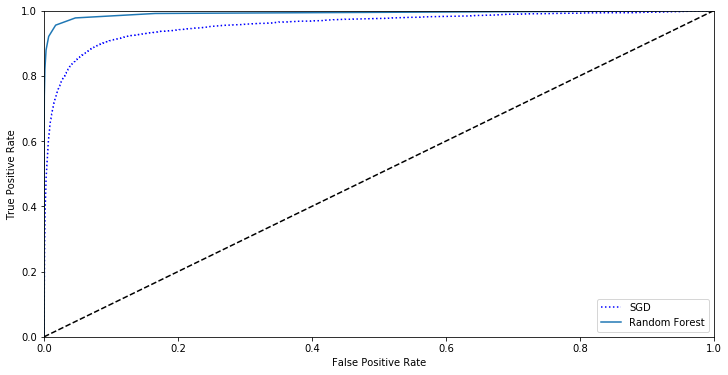

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0,1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

As you can see, the random forest classifier looks much better than SGD as it approaches more to the top-left corner. It is expected then, that the ROC AUC to be greater.

In [33]:
roc_auc_score(y_train_5, y_scores_forest)

0.9919276160871573

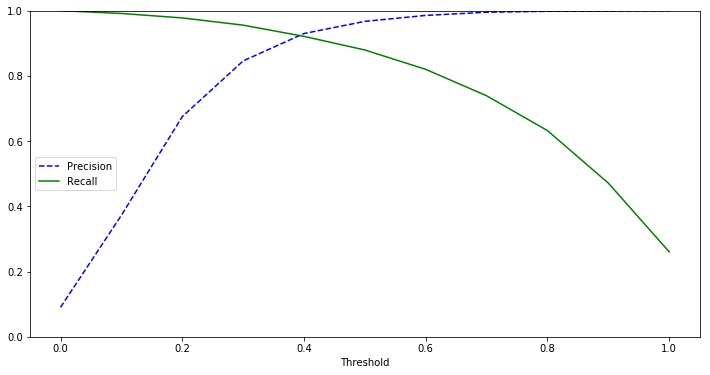

In [34]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_forest)

plot_recision_recall_vs_threshold(precisions, recalls, thresholds)